## Data Load

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
DATA_DIR = Path("../data")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train:", train.shape)
print("test :", test.shape)

train.head()

train: (10886, 12)
test : (6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
# Basic checks
print(train.isna().sum().sort_values(ascending=False).head(10))
print(test.isna().sum().sort_values(ascending=False).head(10))

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


## 2) Feature Engineering
We add **domain-specific time features**:
- Parse `datetime`
- Extract: `year`, `month`, `day`, `hour`, `dayofweek`
- Add cyclical encodings: `sin/cos` for hour and month
- Add `is_weekend`
We also apply a **log transform on the target** (`count`) using `log1p` to reduce skew.

In [6]:

# Domain-specific time features, parsing the datetime into month, year, day, hour, dayofweek.
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Mon

    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # cyclical encoding
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # We drop the 'datetime' col
    df = df.drop(columns=["datetime"])
    return df

train_fe = add_time_features(train)
test_fe  = add_time_features(test)

train_fe.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,year,month,day,hour,dayofweek,is_weekend,hour_sin,hour_cos,month_sin,month_cos
0,1,0,0,1,9.84,14.395,81,0.0,3,13,...,2011,1,1,0,5,1,0.000000,1.000000,0.5,0.866025
1,1,0,0,1,9.02,13.635,80,0.0,8,32,...,2011,1,1,1,5,1,0.258819,0.965926,0.5,0.866025
2,1,0,0,1,9.02,13.635,80,0.0,5,27,...,2011,1,1,2,5,1,0.500000,0.866025,0.5,0.866025
3,1,0,0,1,9.84,14.395,75,0.0,3,10,...,2011,1,1,3,5,1,0.707107,0.707107,0.5,0.866025
4,1,0,0,1,9.84,14.395,75,0.0,0,1,...,2011,1,1,4,5,1,0.866025,0.500000,0.5,0.866025


In [7]:
# Separate features/target (drop leakage columns too)
drop_cols = ["count", "casual", "registered"]

X = train_fe.drop(columns=drop_cols)
y = train_fe["count"].astype(float)

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Ensures validation has same columns/order (checking in case columns are shifted)
X_test = X_test.reindex(columns=X_train.columns)

In [8]:
# Categorize columns' dtypes (Numerical vs. Categorical)
# Separates the input features into numeric and categorical columns so they can be prepared correctly for modeling.
cat_like = ["season", "holiday", "workingday", "weather"]
X[cat_like] = X[cat_like].astype("category")

categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns
numeric_cols = X.select_dtypes(include=["number"]).columns

print("\nCategorical columns:")
print(list(categorical_cols))

print("\nNumeric columns:")
print(list(numeric_cols))


Categorical columns:
['season', 'holiday', 'workingday', 'weather']

Numeric columns:
['temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']



# 3) Model Training

### i) Linear Regression

In [9]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Linear Regression
lr_model = LinearRegression()
lr_fit_model = lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_fit_model.predict(X_test_scaled)

# Calculating all metrics
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression: RMSE={lr_rmse:.4f}, R²={lr_r2:.4f}")
linear_regression_results = {'Model':'Linear Regression', 'RMSE':lr_rmse, 'MAE':lr_mae, 'R²':lr_r2}

Linear Regression: RMSE=125.6603, R²=0.5216


### ii) Lasso Regression

In [10]:
lasso_alphas = [0.1, 1.0, 10.0]
lasso_results = []

for alpha in lasso_alphas:
    Lasso_model=Lasso(alpha)
    lm=Lasso_model.fit(X_train_scaled, y_train)
    lasso_model_pred=lm.predict(X_test_scaled)

    lm_mse= mean_squared_error(y_test, lasso_model_pred)
    lm_rmse = np.sqrt(lm_mse)
    lm_mae= mean_absolute_error(y_test, lasso_model_pred)
    lm_r2= r2_score(y_test, lasso_model_pred)
    print(f'Lasso: RMSE={lm_rmse:.4f}, R²={lm_r2:.4f}')
    lasso_results.append({'Model':f'Lasso (α={alpha})', 'RMSE':lm_rmse, 'MAE':lm_mae, 'R²':lm_r2})

print(f"Lasso models trained: {len(lasso_results)}")

Lasso: RMSE=125.6764, R²=0.5215
Lasso: RMSE=125.7586, R²=0.5209
Lasso: RMSE=128.5453, R²=0.4994
Lasso models trained: 3


### iii) Polynomial Regression

In [11]:
# Polynomial Regression with different degrees
poly_degrees = [2, 3] # Removed 4, as it takes very long to run on the system
poly_results = []

for degree in poly_degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train Linear Regression on polynomial features
    poly_model = LinearRegression()
    poly_fit_model = poly_model.fit(X_train_poly, y_train)

    # Make predictions
    poly_pred = poly_fit_model.predict(X_test_poly)

    # Calculate metrics
    poly_mse = mean_squared_error(y_test, poly_pred)
    poly_rmse = np.sqrt(poly_mse)
    poly_mae = mean_absolute_error(y_test, poly_pred)
    poly_r2 = r2_score(y_test, poly_pred)

    print(f'Polynomial (degree={degree}): RMSE={poly_rmse:.4f}, R²={poly_r2:.4f}')

    poly_results.append({
        'Model': f'Polynomial (degree={degree})',
        'RMSE': poly_rmse,
        'MAE': poly_mae,
        'R²': poly_r2
    })

print(f"Polynomial models trained: {len(poly_results)}")

Polynomial (degree=2): RMSE=95.1535, R²=0.7257
Polynomial (degree=3): RMSE=62.7212, R²=0.8808
Polynomial models trained: 2


# 4) Model Evaluation

In [12]:
# Combining Results
all_results = [
    linear_regression_results,
    *lasso_results,
    *poly_results
]
results_df = pd.DataFrame(all_results).sort_values('R²', ascending=False)

print("\n- MODEL COMPARISON:")
if results_df is not None:
    print(results_df.to_string(index=False))


- MODEL COMPARISON:
                Model       RMSE       MAE       R²
Polynomial (degree=3)  62.721188 44.897257 0.880815
Polynomial (degree=2)  95.153502 68.102606 0.725688
    Linear Regression 125.660253 91.652831 0.521601
        Lasso (α=0.1) 125.676401 91.643507 0.521478
        Lasso (α=1.0) 125.758620 91.427136 0.520851
       Lasso (α=10.0) 128.545257 92.640387 0.499381


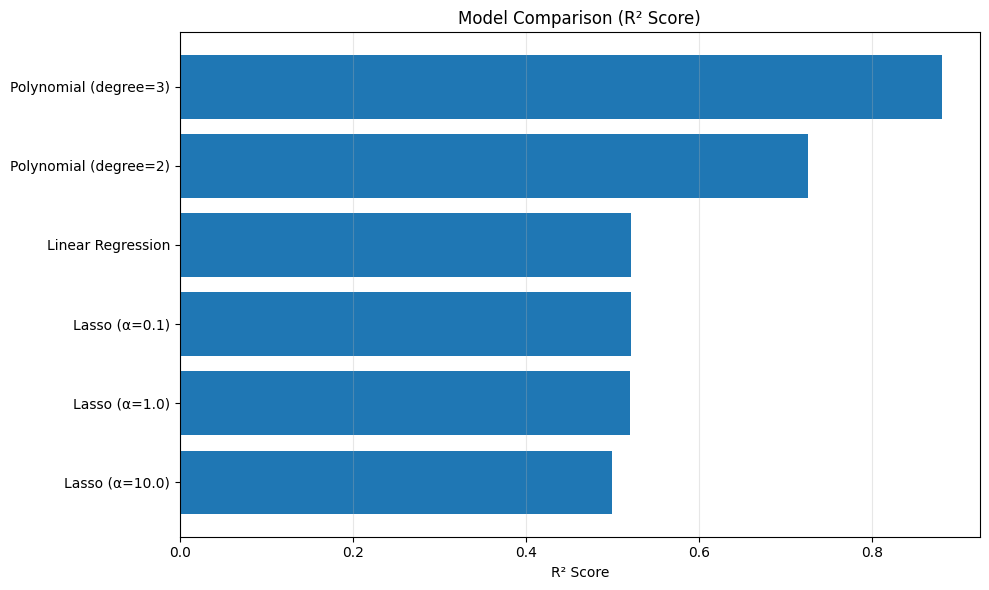

In [13]:
# Sort models by R² (best at top)
results_sorted = results_df.sort_values('R²', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.barh(range(len(results_sorted)), results_sorted['R²'])
plt.yticks(range(len(results_sorted)), results_sorted['Model'])
plt.xlabel('R² Score')
plt.title('Model Comparison (R² Score)')
plt.gca().invert_yaxis()  # Highest R² at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Predicted vs. Actual Plots

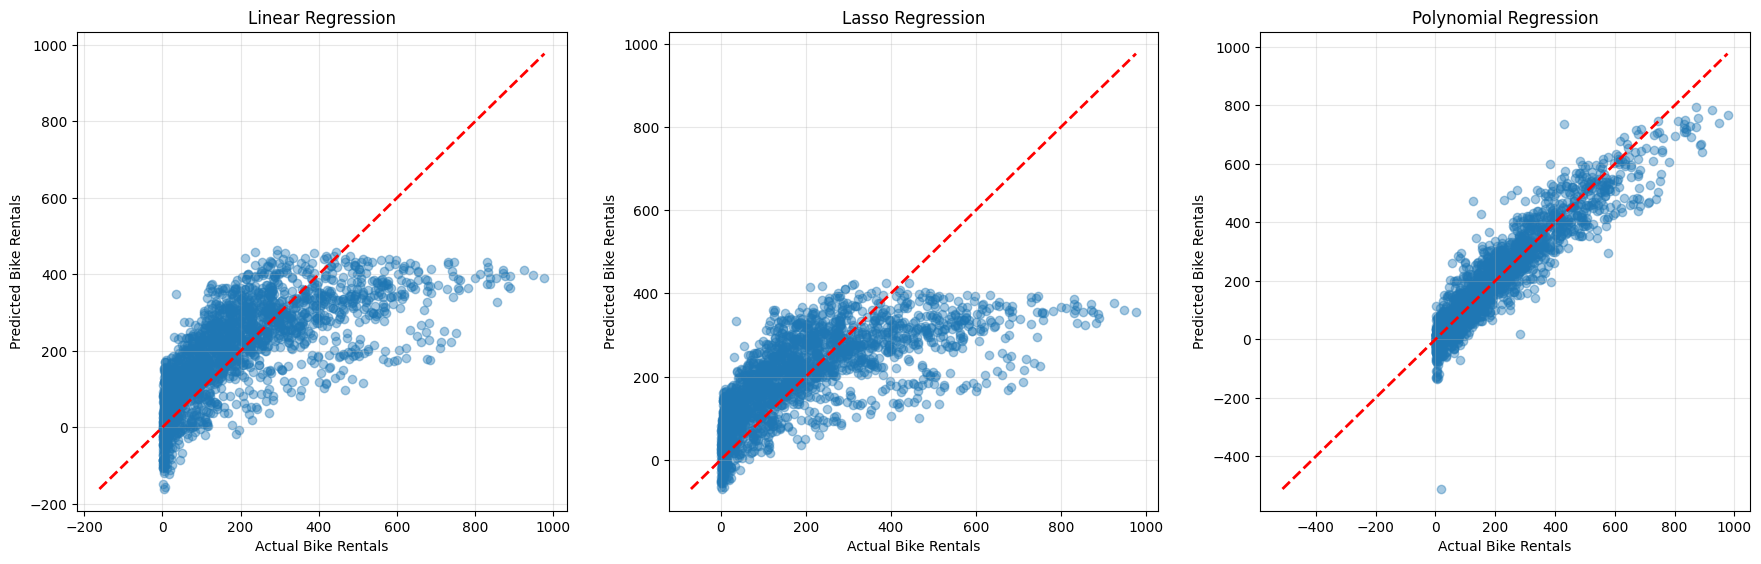

In [14]:
models = {
    "Linear Regression": lr_pred,
    "Lasso Regression": lasso_model_pred,
    "Polynomial Regression": poly_pred
}

plt.figure(figsize=(18, 6))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)

    plt.scatter(y_test, preds, alpha=0.4)

    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())

    # Perfect prediction line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.title(f"{name}")
    plt.xlabel("Actual Bike Rentals")
    plt.ylabel("Predicted Bike Rentals")
    plt.grid(alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()


### Predicted vs. Actual + Residual Plots (Best Model Only)

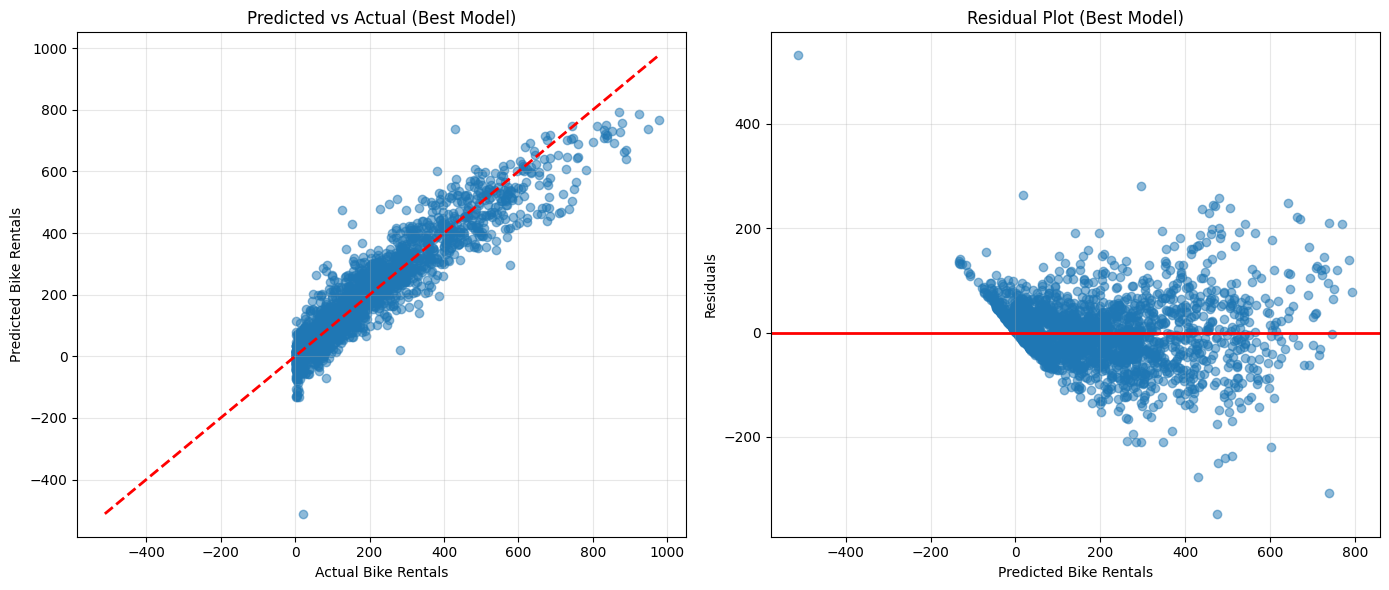

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# -----------------------------
# Predicted vs Actual Plot
# -----------------------------
ax1.scatter(y_test, poly_pred, alpha=0.5)

min_val = min(y_test.min(), poly_pred.min())
max_val = max(y_test.max(), poly_pred.max())

# Perfect prediction line
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_xlabel('Actual Bike Rentals')
ax1.set_ylabel('Predicted Bike Rentals')
ax1.set_title('Predicted vs Actual (Best Model)')
ax1.grid(True, alpha=0.3)

# -----------------------------
# Residual Plot
# -----------------------------
residuals = y_test - poly_pred

ax2.scatter(poly_pred, residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linewidth=2)

ax2.set_xlabel('Predicted Bike Rentals')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot (Best Model)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance


📊 Feature Importance (Top 10):
         Feature   Coefficient  Abs_Coefficient
   hour hour_cos -7.131366e+08     7.131366e+08
          hour^3 -2.638192e+08     2.638192e+08
 hour hour_sin^2  2.192236e+08     2.192236e+08
hour month_cos^2  2.170217e+08     2.170217e+08
            hour  2.162884e+08     2.162884e+08
     year^2 hour  2.162795e+08     2.162795e+08
hour month_sin^2  2.125697e+08     2.125697e+08
 hour hour_cos^2  2.112198e+08     2.112198e+08
 hour^2 hour_sin -1.796098e+08     1.796098e+08
  hour month_cos -1.400237e+08     1.400237e+08


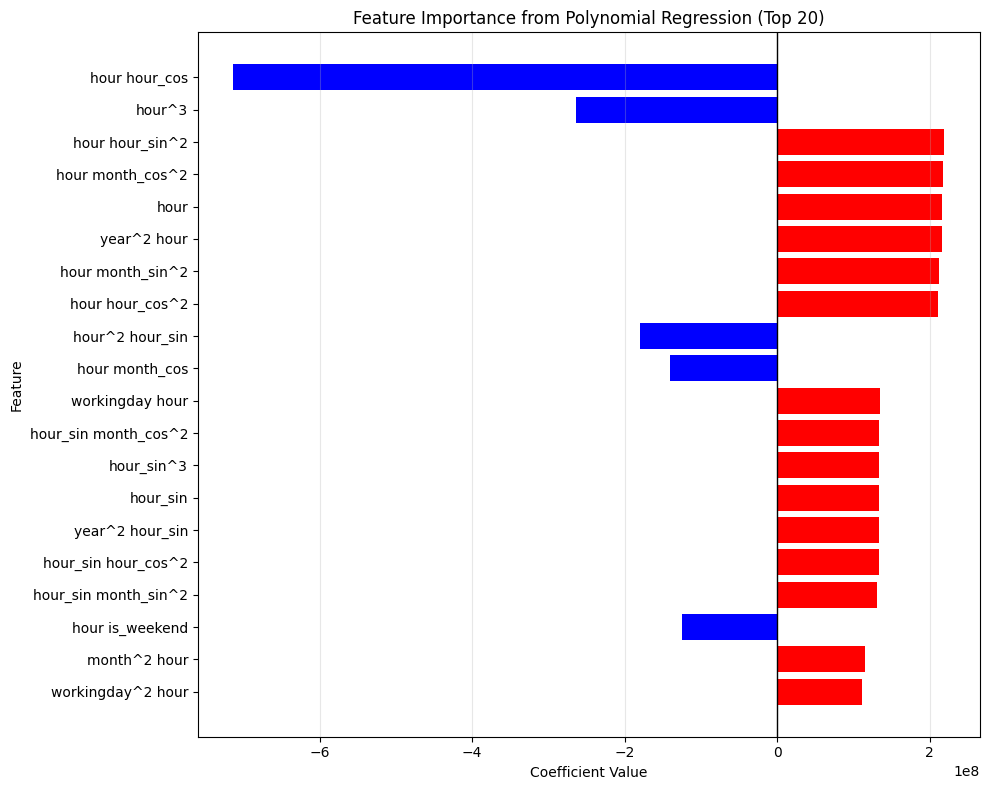

In [16]:
# Get feature names after polynomial transformation (use the ORIGINAL column names)
feature_names_poly = poly.get_feature_names_out(X_train.columns)

# Create DataFrame with features and coefficients from poly_model
feature_importance = pd.DataFrame({
    'Feature': feature_names_poly,
    'Coefficient': poly_model.coef_
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\n📊 Feature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance (Top N only)
TOP_N = 20
top_feats = feature_importance.head(TOP_N).copy()

plt.figure(figsize=(10, 8))

# Color positive vs negative coefficients
colors = ['red' if c > 0 else 'blue' for c in top_feats['Coefficient']]

plt.barh(top_feats['Feature'][::-1], top_feats['Coefficient'][::-1], color=colors[::-1])

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Feature Importance from Polynomial Regression (Top {TOP_N})')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# Analysis